## Signal Processing ENU
August 4, Intern: Diego Varela, Mentor: Surendra Adhikari

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import pandas as pd

In [3]:
data_folder = '/Users/diego/Desktop/NASA/SignalProcessing/data/ENU_v2' # path to the folder with the data 
locations = ['AASI', 'ASKY', 'AVAN', 'BLAS', 'DANE', 'DGJG'] # Name of some locations


def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

In [4]:
np.shape(get_data(locations[0]))

(6385, 7)

Data file has shape (features, variables). This is how they look like:
 
 | Time (years) | East (mm) | North (mm) | Up (mm) | East_error (mm) | North_error (mm) | Up_error (mm) |
 | ------------ | --------- | ---------- | ------- | --------------- | ---------------- | --------------|
 | 2005.746739  |  81.1990  | -44.5710   | -22.8590|   0.7640        | 1.0650  |  3.8750 |
 | entry 2 ... |   entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |


In [6]:
AASI = get_data('AASI')
AASI_time = AASI[:,0]
AASI_data = AASI[:,1:4]
AASI_error = AASI[:,4:]

AASI_data_detrended = scipy.signal.detrend(AASI_data, axis = 0)

What I am doing with the data:
1. Plots of the Raw Data
2. Detrended data using scipy:  Average is set to zero. 
3. Fast Fourier Transformations: Through frequency, we can observe how often does the signal repeat (i.e. how long are seasons), 
4. PCA: Understand the main drivers of the signal change.

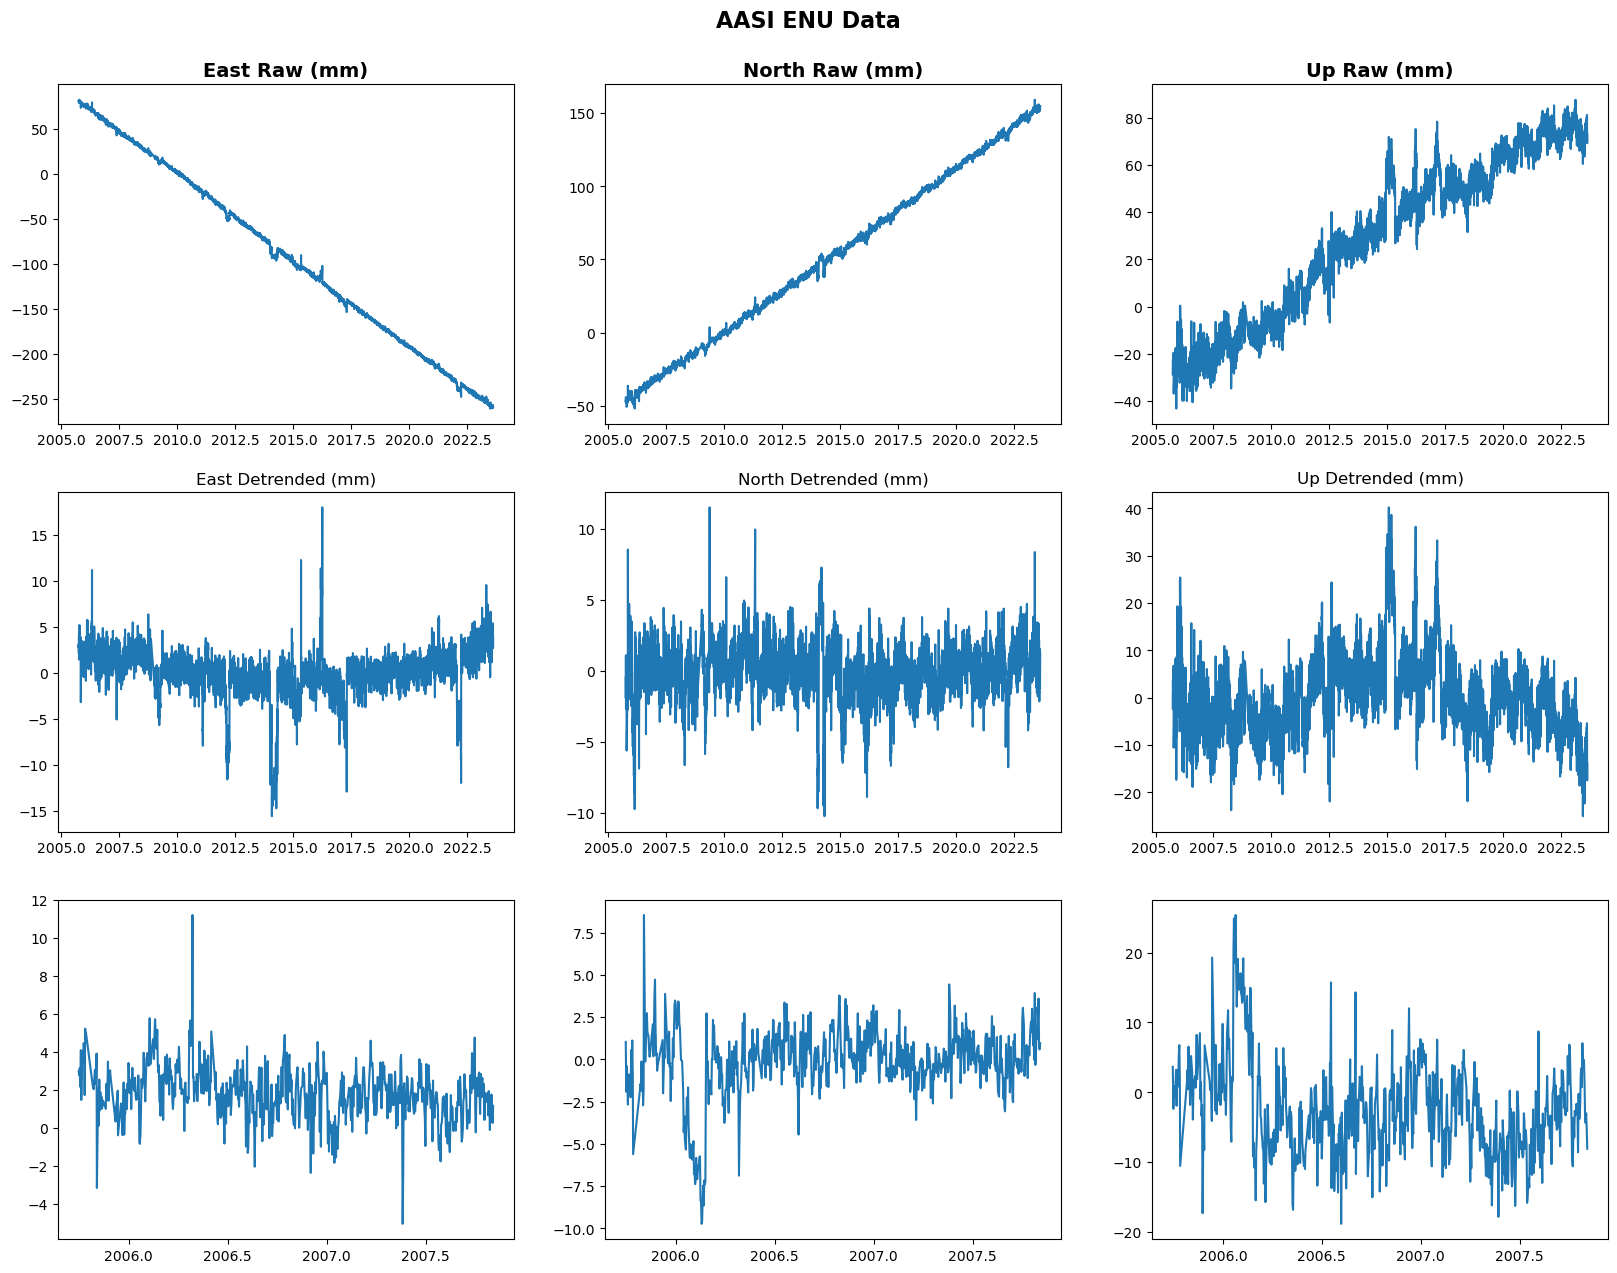

In [8]:
years = 2 
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
titles = ['East (mm)', 'North (mm)', 'Up (mm)']

axs[0,0].plot(AASI_time, AASI_data[:,0])
axs[0,1].plot(AASI_time, AASI_data[:,1])
axs[0,2].plot(AASI_time, AASI_data[:,2])

axs[1,0].plot(AASI_time, AASI_data_detrended[:,0])
axs[1,1].plot(AASI_time, AASI_data_detrended[:,1])
axs[1,2].plot(AASI_time, AASI_data_detrended[:,2])

axs[2,0].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,0])
axs[2,1].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,1])
axs[2,2].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,2])

axs[0,0].set_title('East Raw (mm)', weight = 'bold', size = 14)
axs[0,1].set_title('North Raw (mm)', weight = 'bold', size = 14)
axs[0,2].set_title('Up Raw (mm)', weight = 'bold', size = 14)

axs[1,0].set_title('East Detrended (mm)', size = 12)
axs[1,1].set_title('North Detrended (mm)', size = 12)
axs[1,2].set_title('Up Detrended (mm)', size = 12)

fig.suptitle('AASI ENU Data', weight= 'bold', size = 16, y = 0.93)
plt.show()

## Detrended Climatology 
Changed dates from decimals to datetime and made into a pandas dataframe for easier manipulation.

In [34]:
import datetime

def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date

# Example usage:
decimal_year_value = AASI_time[1261]
date_result = decimal_year_to_date(decimal_year_value)
print(f"The decimal year {decimal_year_value} converts to: {date_result}")

The decimal year 2009.508546 converts to: 2009-07-05


In [40]:
converted_dates = np.array([decimal_year_to_date(dy) for dy in AASI_time])

In [103]:
df = pd.DataFrame({'date':converted_dates})
df['east'] = pd.Series(AASI_data_detrended[:,0])
df['north'] = pd.Series(AASI_data_detrended[:,1])
df['up'] = pd.Series(AASI_data_detrended[:,2])

df.set_index('date', inplace=True)
df

climatology = df.groupby('date').mean('date').values 
climatology

array([[  2.98967336,   1.03351148,   3.63920756],
       [  2.75302611,  -1.91668289,  -2.36450884],
       [  3.15137886,  -0.39787726,   0.34277477],
       ...,
       [  5.06092576,   0.76704546, -12.9518216 ],
       [  2.79127851,   0.99885109, -17.44853799],
       [  3.97463126,   1.29165672, -13.88425438]])

In [109]:
df['month_day'] = df.index.map(lambda x: x.strftime('%m-%d'))

climatology = df.groupby('month_day')[['east', 'north', 'up']].mean()
climatology

df['month'] = df.index.map(lambda x: x.strftime('%m'))
climatology_monthly = df.groupby('month')[['east', 'north', 'up']].mean()
climatology_monthly

,east,north,up
month_day,,,
01-01,0.410411,0.411309,1.510171
01-02,-0.185466,0.585506,2.518937
01-03,-0.398871,0.642452,1.020709
01-04,-0.250606,0.383957,2.429285
01-05,-0.608728,0.245313,2.354964
...,...,...,...
12-27,-0.263127,0.091797,2.683176
12-28,-0.440362,0.118132,2.605989
12-29,-0.082539,0.869702,2.297684


In [139]:
df['month'] = df.index.map(lambda x: x.strftime('%m'))
climatology_monthly = df.groupby('month')[['east', 'north', 'up']].mean()
climatology_monthly

,east,north,up
month,,,
01,-0.384451,-0.482987,3.012486
02,-1.303921,-0.967811,3.106663
03,-1.001880,-1.098701,2.123967
04,-0.068876,-0.496829,-1.741947
05,0.706615,0.288523,-5.423632
06,0.773836,0.391350,-5.766909
07,0.536791,0.300031,-3.595933
08,0.156033,0.069114,0.336652
09,0.041939,0.378967,2.573274


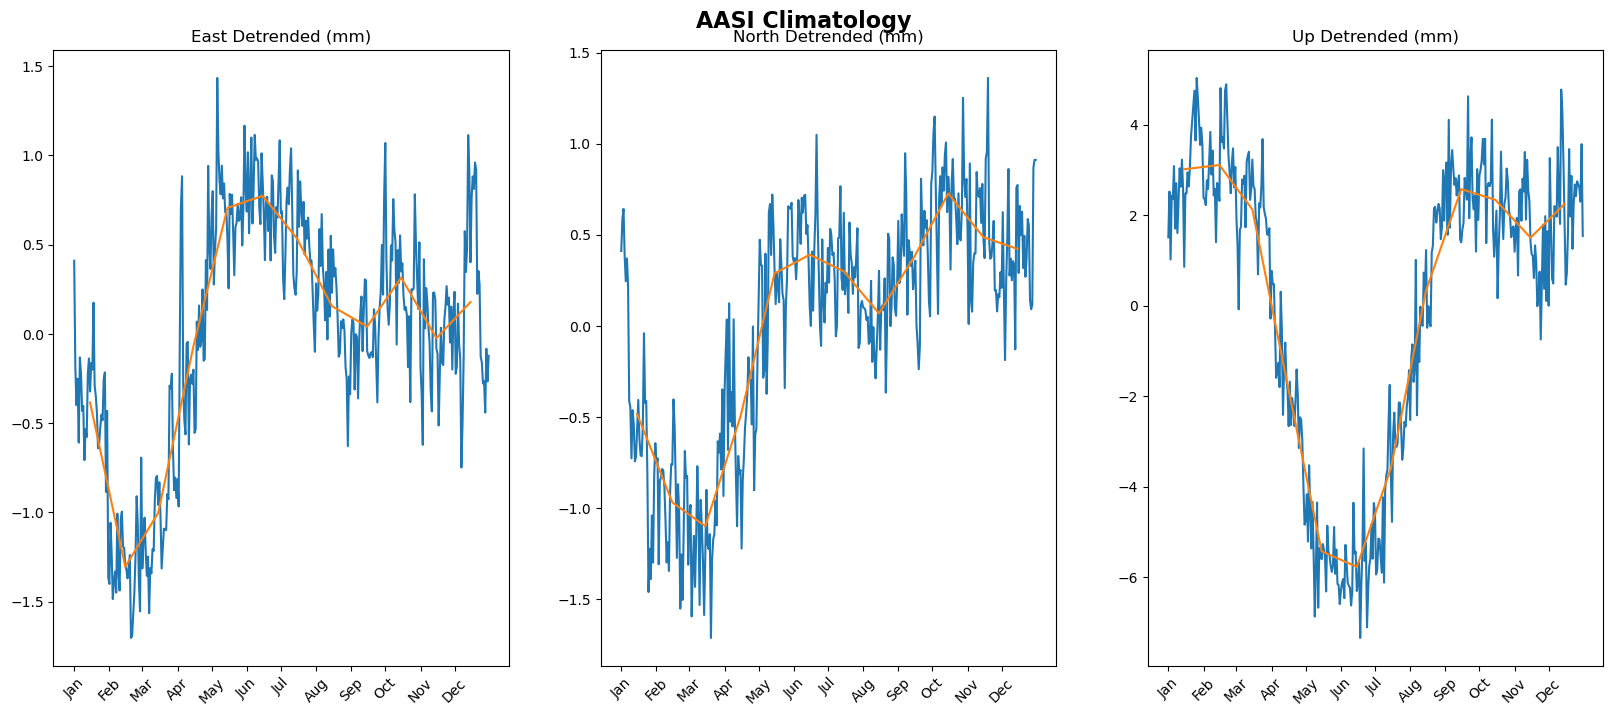

In [145]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_ticks = [f'{month:02d}-01' for month in range(1, 13)]

axs[0].plot(climatology['east'])
axs[1].plot(climatology['north'])
axs[2].plot(climatology['up'])

monthly_aligned_index = [f"{month}-15" for month in climatology_monthly.index]

axs[0].plot(monthly_aligned_index, climatology_monthly['east'])
axs[1].plot(monthly_aligned_index, climatology_monthly['north'])
axs[2].plot(monthly_aligned_index, climatology_monthly['up'])

for ax in axs:
    ax.set_xticks(month_ticks) 
    ax.set_xticklabels(Time_months, rotation=45)
    
axs[0].set_title('East Detrended (mm)', size = 12)
axs[1].set_title('North Detrended (mm)', size = 12)
axs[2].set_title('Up Detrended (mm)', size = 12)

fig.suptitle('AASI Climatology', weight= 'bold', size = 16, y = 0.93)
plt.show()

## EOF & PCA Analysis
By doing so, we can break into smaller parts the signals, allowing us to isolate seasonality from variability

In [75]:
from eofs.standard import Eof

In [155]:
df

,east,north,up,doy,month_day,month
date,,,,,,
2005-09-30,2.989673,1.033511,3.639208,273,09-30,09
2005-10-01,2.753026,-1.916683,-2.364509,274,10-01,10
2005-10-02,3.151379,-0.397877,0.342775,275,10-02,10
2005-10-03,2.149732,-1.152072,0.848058,276,10-03,10
2005-10-04,4.090084,-2.670266,-0.566658,277,10-04,10
...,...,...,...,...,...,...
2023-08-16,5.419220,-0.318566,-5.453389,228,08-16,08
2023-08-17,4.520573,-1.277760,-13.297105,229,08-17,08
2023-08-18,5.060926,0.767045,-12.951822,230,08-18,08


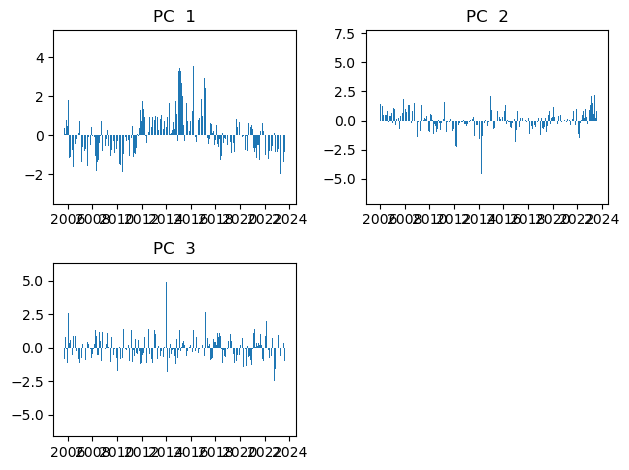

In [167]:
solver = Eof(AASI_data_detrended)
eofs = solver.eofsAsCovariance(neofs = 4)

pc4 = solver.pcs(npcs=4, pcscaling=1)
a=1

for i in range(len(pc4[0])):
    plt.subplot(2, 2, i+1)
    plt.bar(converted_dates,pc4[:,i])
    plt.title('PC  %i' %a)
    a+=1
    
plt.tight_layout()